***This notebook needs to be executed in pyvizenv env to display all the images in panel 
and needs python-dotenv  to load env variables***

This can be done by activating the pyvizenv env and also loading the alpaca apis using below commands

- conda activate pyvizenv
- pip install python-dotenv

***This notebook gets the NFT collections data using OpenSea API and current ETH price using Alpaca API**
Therefore to run the notebook the API keys for OpenSea API and Alpacha API needs to be defined in the .env file as below
- opensea_api_key="XXXXXXXXXX"
- ALPACA_API_KEY="XXXXXXXXXX"
- ALPACA_SECRET_KEY="XXXXXXXXXX"


In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import json
from datetime import datetime 
from alpaca_trade_api.rest import REST, TimeFrame
import time
from time import sleep
import datetime
import csv
%matplotlib inline
from IPython.display import Image
from IPython.core.display import HTML 
import panel as pn
pn.extension('plotly')
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import date



Bad key savefig.frameon in file /Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  #

In [2]:
# Load .env enviroment variables
load_dotenv()
opensea_api_key = os.getenv("opensea_api_key")
# define headers as global variable it is used in multiple get API calls
headers = {
        "Accept": "application/json",
        "X-API-KEY": opensea_api_key
    }


In [3]:
#The event data for different NFT collections are retreived for 6 months based on below start/end dates
start_date = datetime.datetime(2021, 10, 1)
end_date = datetime.datetime(2022, 3, 31)

In [4]:

asset_base_url = "https://api.opensea.io/api/v1/assets"
collection_slug="boredapeyachtclub"

#this function will invoke opensea API to get different assets in the NFT collection
# it takes the collection name and the limit of assets to be fetched
def get_asset(collection_slug,limit):
    
    query = { 
        "include_orders":False,
        "collection_slug":collection_slug,
        "limit":limit
    }
    response = requests.request("GET", asset_base_url, headers=headers,params=query)
    return response.json()

asset_limit=200
doodle_assets_data=get_asset(collection_slug,asset_limit)
#print(json.dumps(doodle_assets,indent=4))
doodle_assets = doodle_assets_data["assets"]
#print(json.dumps(doodle_assets,indent=4))

#this function will iterater over the asset json data and get the thumbnail image URL
# it will return a list of thumbnail URLs
def get_asset_image_urls(assets):
    asset_image_urls=[]
    for asset in assets:
        asset_image_thumbnail_url = asset["image_thumbnail_url"]
        if asset_image_thumbnail_url is not None:
            asset_image_urls.append(asset_image_thumbnail_url)
    return asset_image_urls

asset_image_urls = get_asset_image_urls(doodle_assets)

total_images_to_display=10

#this method will pick random thumbnail URLs from the list and fetch images using the URL
# it will create a panel row with the images and add the row to the panel column
# and will return the column
def create_panel(asset_image_urls,total_images_to_display):
    image_rows = pn.Row()
    for i in range(0,total_images_to_display):
        random_url = np.random.choice(asset_image_urls)
        im = Image.open(requests.get(random_url, stream=True).raw)
        fig = get_image_figure(im)
        image_rows.append(fig)
    panel_column = pn.Column(image_rows)
    return panel_column

#this function takes the image object and wraps it in a figure and returns
# the figure 
def get_image_figure(image):
    fig=plt.figure(figsize=(0.75,0.75))
    plt.imshow(image)
    plt.close(fig)
    return fig

create_panel(asset_image_urls,total_images_to_display)

asset_limit=200
total_images_to_display=10

# this is a function that consolidates all above functions 
# i.e 1) fetch asset data 2) get image URL from response JSON 3) create image and add it to panel
def display_colleaction_assets(collection_slug,asset_limit,total_images_to_display):
    collection_slug_assets_data=get_asset(collection_slug,asset_limit)
    collection_slug_assets = collection_slug_assets_data["assets"]
    asset_image_urls = get_asset_image_urls(collection_slug_assets)
    panel = create_panel(asset_image_urls,total_images_to_display)
    return panel



Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
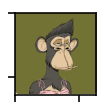
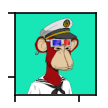
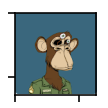
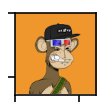
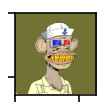
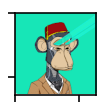
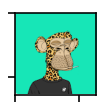
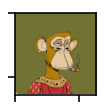
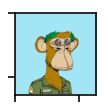
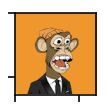

In [5]:
#invoke the function with the collection name and display 
# random thumbnails of the NFTs in the collection
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel



In [6]:
#this function invokes the opensea API to get the successful events for a NFT collection
# for a particular date range
def get_events(url,start_date, end_date,event_type, collection_slug,limit=1, cursor=''):
    
    query = { 
        "only_opensea": "true", 
        "occurred_before": end_date,
        "occurred_after": start_date,
        "event_type":event_type,
        "collection_slug":collection_slug,
        "limit":limit,
        "cursor": cursor
    }
    
    response_data = requests.request("GET", url, headers=headers, params=query)
    json_data = response_data.json()
    #print(json_data)
    return json_data

In [7]:
collection_stats_base_url = "https://api.opensea.io/api/v1/collection/"
def get_colection_stats(collection_slug):
    url = collection_stats_base_url+collection_slug+"/stats"
    
    response_data = requests.request("GET", url, headers=headers)
    json_data = response_data.json()
    return json_data

#get the stats for the collection for analysis
all_collection_stats={}
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats



***The below function parse_event was available on github repo**
Ref - https://github.com/Checco9811/opensea-api-nft-sales/blob/main/script.py

In [8]:
#this function parses the event JSON data and gets the data of interest 
# and creates a new dictinary object and returns that
def parse_event(event):
    record = {}
    asset = event.get('asset')
    if asset == None:
        return None # if there's no asset that means it's not a single NFT transaction so skip this item

    #collection
    record['collection_slug'] = asset['collection']['slug']
    record['collection_name'] = asset['collection']['name']
    record['collection_url'] = "https://opensea.io/collection/" + asset['collection']['slug']

    #asset
    record['asset_id'] = asset['id']
    record['asset_name'] = asset['name']
    record['asset_description'] = asset['description']
    record['asset_contract_date'] = asset['asset_contract']['created_date']
    record['asset_url'] = asset['permalink']
    record['asset_img_url'] = asset['image_url']

    #event
    record['event_id'] = event['id']
    record['event_time'] = event.get('created_date')
    record['event_auction_type'] = event.get('auction_type')
    record['event_contract_address'] = event.get('contract_address')
    record['event_quantity'] = event.get('quantity')
    record['event_payment_symbol'] =  None if event.get('payment_token') == None else event.get('payment_token').get('symbol')

    decimals = 18
    if event.get('payment_token') != None:
        decimals = event.get('payment_token').get('decimals')

    price_str = event['total_price']

    try: 
        if len(price_str) < decimals:
            price_str =  "0." + (decimals-len(price_str)) * "0" + price_str
            record['event_total_price'] = float(price_str)
        else:
            record['event_total_price'] = float(price_str[:-decimals] + "." + price_str[len(price_str)-decimals:])
    except:
        print(event)

    return record

In [9]:
pause = 1
#this function consolidates the invocation to calling API to get the events and 
# parsing the event json data and returns a list

def fetch_all_events(url,start_date, end_date,event_type,collection_slug,limit, pause=1):
    result = list()
    next = ''
    fetch = True

    print(f"Fetching events between {start_date} and {end_date}")
    i =1
    while fetch:
        response = get_events(url,start_date,end_date,event_type,collection_slug, limit, cursor=next)

        for event in response['asset_events']:
            cleaned_event = parse_event(event)
            
            if cleaned_event != None:
                result.append(cleaned_event)
        
        if response['next'] is None:
            fetch = False
        else:
            next = response['next']
        print(f"fetching events for collection:{collection_slug},sleeping for:{pause}, iteration: {i}, limit:{limit}")
        i=i+1
        sleep(pause)

    return result

In [10]:
event_url = "https://api.opensea.io/api/v1/events";
event_type = "successful"
collection_slug = "boredapeyachtclub"

limit = 300

def determine_file_name(collection_slug,start_date,end_date):
    str_start_date = start_date.strftime("%m%d%Y") 
    str_end_date = end_date.strftime("%m%d%Y") 
    file_name = "Data/"+collection_slug+"_"+str_start_date+"_"+str_end_date+".csv"
    return file_name

file_name = determine_file_name(collection_slug,start_date,end_date)
#print(file_name)



In [11]:

#this function writes the event data to a csv file to avoid calling the API multiple times
# for the same date range
def write_csv(data, file_name):
    with open(file_name, mode='w', encoding='utf-8', newline='\n') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames = data[0].keys())

        writer.writeheader()
        for event in data:
            writer.writerow(event)
            

In [12]:
# this NFT collection has different assets which will have different prices based on various attributes 
# like rarity. For the sake of simplicity, we will consider the min/floor price of any of the asset
# for a particular day to determine the floor price of the collection for that day
# this function will interate though all the rows and check for different prices for a day.
# it will then pick the min of the price as the floor price for that day (irrespective of the assetId)
def consolidate_price_data_for_dates(df):
    prices_per_day={}
    for i in range(0, len(df)):
        event_date = df.iloc[i]['event_date']
        event_total_price = df.iloc[i]['event_total_price']
        #print(event_date,event_total_price )
        if event_date in prices_per_day:
            value_event_date = prices_per_day.get(event_date)
            value_event_date.append(event_total_price)
        else:
            prices_per_day[event_date]= [event_total_price]

    return prices_per_day

#prices_per_day = consolidate_price_data_for_dates(nft_event_price_df)
#prices_per_day

# once the dictonary is created with key as date and values as different prices for that date,
# iterate over the dictionary, to get the lowest value for that date and create another dictionary

def get_mean_price_data(prices_per_day):
    floor_prices={}
    for key in prices_per_day:
        prices_for_current_day = prices_per_day[key]
        floor_price_current_day = np.mean(prices_for_current_day)
        floor_prices[key]= floor_price_current_day
        #print(key, 'corresponds to', floor_prices[key],floor_price_current_day)
    return floor_prices



#floor_prices = get_floor_price_data(prices_per_day)
#floor_prices

In [13]:
#df = pd.DataFrame.from_dict(floor_prices)
#df =pd.DataFrame(floor_prices.items(), columns=['event_date', 'close'])
#df.plot()

In [14]:
event_url = "https://api.opensea.io/api/v1/events";
event_type = "successful"
collection_slug = "boredapeyachtclub"
limit =300
file_name = determine_file_name(collection_slug,start_date,end_date)

def fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                        file_name):

    path = Path(file_name)
    if path.is_file():
        print(f'The file {file_name} exists')
    else:
        result = fetch_all_events(event_url,start_date,end_date,event_type,collection_slug, limit)
        print(f"total number of records found:{len(result)}")
        print(f"writing data to file:{file_name}")
        write_csv(result, file_name)
    
    
    nft_events_df = pd.read_csv(file_name)
    nft_event_price_df=nft_events_df[['asset_id','event_time','event_total_price']]

    nft_event_price_df['event_time']= pd.to_datetime(nft_events_df['event_time']).dt.date
    nft_event_price_df.rename(columns = {'event_time':'event_date'}, inplace = True)

    #nft_event_price_df =nft_event_price_df.set_index("event_date")
    #nft_event_price_df
    prices_per_day = consolidate_price_data_for_dates(nft_event_price_df)
    floor_prices = get_mean_price_data(prices_per_day)
    df =pd.DataFrame(floor_prices.items(), columns=['event_date', 'close'])
    
    #get the dataframe close column and calculate rolling median
    df_close = df[["close"]]
    df_close = df_close.rolling(5).median() 
    
    # re-assign the close column of the dataframe (first 4 rowa will be NAN)
    df['close'] = df_close
    #drop the rows having null data due to rolling median
    df.dropna(inplace=True)


    
    df = df.sort_values(by="event_date",axis=0, ascending=True )
    df = df.set_index('event_date')
    # Concatenate the ticker DataFrames
    df_mc = pd.concat([df], axis=1, keys=[collection_slug])
    return df_mc

In [15]:
df_boredapeyachtclub = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_boredapeyachtclub

The file Data/boredapeyachtclub_10012021_03312022.csv exists


/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,boredapeyachtclub
,close
event_date,
2021-10-01,46.080652
2021-10-02,45.202688
2021-10-03,45.154615
2021-10-04,45.154615
2021-10-05,45.154615
...,...
2022-03-22,115.926779
2022-03-23,115.926779


In [16]:

def get_floor_price_data(prices_per_day):
    floor_prices={}
    for key in prices_per_day:
        prices_for_current_day = prices_per_day[key]
        floor_price_current_day = min(prices_for_current_day)
        floor_prices[key]= floor_price_current_day
        #print(key, 'corresponds to', floor_prices[key],floor_price_current_day)
    return floor_prices

nft_events_df = pd.read_csv(file_name)
nft_event_price_df=nft_events_df[['asset_id','event_time','event_total_price']]

nft_event_price_df['event_time']= pd.to_datetime(nft_events_df['event_time']).dt.date
nft_event_price_df.rename(columns = {'event_time':'event_date'}, inplace = True)
prices_per_day = consolidate_price_data_for_dates(nft_event_price_df)
floor_prices_1 = get_floor_price_data(prices_per_day)
floor_prices_1_df =pd.DataFrame(floor_prices_1.items(), columns=['event_date', 'close'])

df_close = floor_prices_1_df[["close"]]
df_close = df_close.rolling(5).median() 
df_close

floor_prices_1_df['close'] = df_close
floor_prices_1_df.dropna(inplace=True)
floor_prices_1_df

/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,event_date,close
4,2022-03-26,95.010000
5,2022-03-25,95.010000
6,2022-03-24,96.500000
7,2022-03-23,97.000000
8,2022-03-22,99.416835
...,...,...
176,2021-10-05,34.120000
177,2021-10-04,34.120000
178,2021-10-03,35.269000
179,2021-10-02,37.891000


<AxesSubplot:xlabel='event_date'>

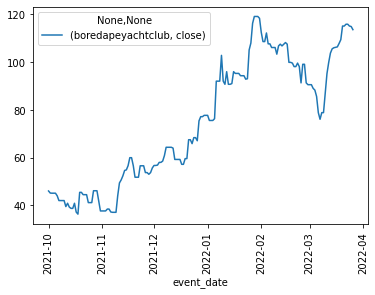

In [17]:
#prepare the datafame for Monte Carlo simulation


#df = df.sort_values(by="event_date",axis=0, ascending=True )
#df = df.set_index('event_date')
# Concatenate the ticker DataFrames
#df_mc = pd.concat([df], axis=1, keys=["NFT"])

# Display sample data
#df_mc



df_boredapeyachtclub.plot(rot=90)


In [18]:
num_of_simulation =100
#num_of_years=1
#num_trading_days = 252*num_of_years
num_trading_days=30

MC_df_boredapeyachtclub = MCSimulation(
    portfolio_data = df_boredapeyachtclub,
    num_simulation = num_of_simulation,
    num_trading_days = num_trading_days
)

In [19]:
# Printing the simulation input data
MC_df_boredapeyachtclub.portfolio_data.head()

boredapeyachtclub             
                       close daily_return
event_date                               
2021-10-01         46.080652          NaN
2021-10-02         45.202688    -0.019053
2021-10-03         45.154615    -0.001064
2021-10-04         45.154615     0.000000
2021-10-05         45.154615     0.000000

In [20]:
# Running a Monte Carlo simulation to forecast for 1 year cumulative returns
MC_df_boredapeyachtclub.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.054855,1.001508,0.902698,1.091847,1.039623,0.992733,1.005514,1.084053,1.032227,0.996853,...,1.008340,1.038822,0.954394,1.040850,0.977633,0.943695,1.070917,1.008358,0.974381,1.072732
2,1.060434,0.961344,0.901333,1.154285,1.035149,1.078755,1.060822,1.157260,1.110535,1.052419,...,1.095752,1.097703,0.992758,0.967984,1.036850,0.901006,1.129950,1.100432,1.077871,1.111923
3,1.145802,1.011513,0.969202,1.139693,1.087122,1.092206,1.048438,1.097513,1.041353,1.117486,...,1.069802,1.102492,0.955404,1.074373,1.021179,0.891290,1.100930,1.079980,1.070843,1.131964
4,1.169411,1.067313,0.938863,1.176840,1.120794,0.981248,1.020546,1.114842,1.055972,1.135108,...,1.172945,1.221459,0.952002,0.994303,0.975130,0.924560,1.070866,1.038237,1.053598,1.241246
5,1.280185,1.130833,0.964728,1.092383,1.279901,1.068462,1.004896,1.221926,1.096167,1.116770,...,1.219082,1.155041,0.922039,0.946083,0.962324,0.890095,1.028340,1.047885,1.044943,1.179308
6,1.200070,1.167355,0.992386,1.076383,1.272177,1.095636,1.002979,1.222634,1.150722,1.068520,...,1.288897,1.106355,0.954299,0.960903,1.009634,0.875853,1.046001,1.023415,1.072776,1.187842
7,1.162854,1.159254,1.010081,1.057160,1.309739,1.155626,0.957133,1.246296,1.130099,1.078714,...,1.349934,1.110180,0.953859,0.985961,1.028804,0.878457,1.092593,1.115299,1.026583,1.166225
8,1.101041,1.131597,0.970493,1.045740,1.313804,1.138853,0.941333,1.335901,1.197993,1.071545,...,1.422839,1.036513,1.004252,1.004092,1.086498,0.934763,1.033723,1.227501,1.009878,1.226821
9,1.107715,1.119661,1.066911,1.043936,1.355216,1.231780,1.041955,1.325628,1.292965,1.105247,...,1.370404,0.966907,1.042028,0.963759,1.117113,0.889704,0.986363,1.294769,0.974854,1.180560


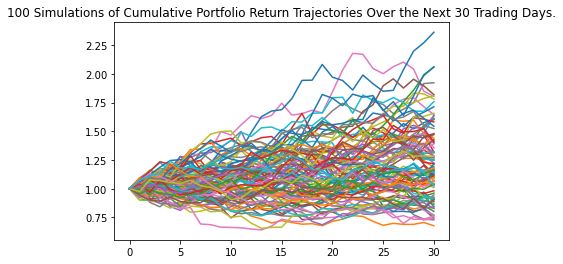

In [21]:
def determine_simulation_image_name(collection_slug):
    return "Images/"+collection_slug+"_sim_plot.png"

def determine_distribution_image_name(collection_slug):
    return "Images/"+collection_slug+"_dist_plot.png"

sim_image_name=determine_simulation_image_name(collection_slug)

# Plot simulation outcomes
line_plot = MC_df_boredapeyachtclub.plot_simulation()
line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")

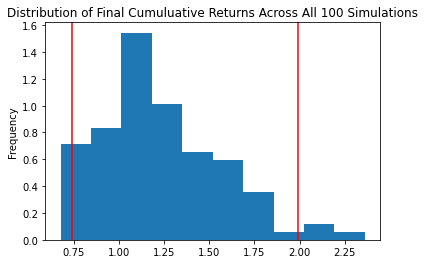

In [22]:
# Plot probability distribution and confidence intervals
dist_plot = MC_df_boredapeyachtclub.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [23]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_df_boredapeyachtclub.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           100.000000
mean              1.230944
std               0.335742
min               0.677525
25%               1.002271
50%               1.164457
75%               1.420603
max               2.361617
95% CI Lower      0.742319
95% CI Upper      1.993185
Name: 30, dtype: float64


Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
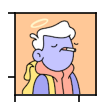
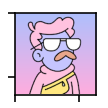
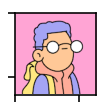
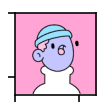
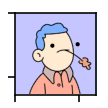
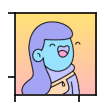
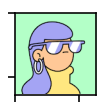
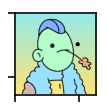
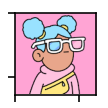
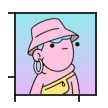

In [24]:
collection_slug="doodles-official"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

The file Data/doodles-official_10012021_03312022.csv exists


/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:xlabel='event_date'>

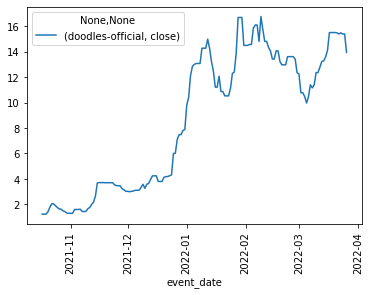

In [25]:
collection_slug = "doodles-official"

#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)
df_doodles = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_doodles.plot(rot=90)

In [26]:
num_of_simulation =100
#num_of_years=1
#num_trading_days = 252*num_of_years
num_trading_days=30

doodles_MC = MCSimulation(
    portfolio_data = df_doodles,
    num_simulation = num_of_simulation,
    num_trading_days = num_trading_days
)

# Printing the simulation input data
doodles_MC.portfolio_data.head()


doodles-official             
                      close daily_return
event_date                              
2021-10-17         1.227571          NaN
2021-10-18         1.227571     0.000000
2021-10-19         1.227571     0.000000
2021-10-20         1.394365     0.135874
2021-10-21         1.747947     0.253579

In [27]:

# Running a Monte Carlo simulation to forecast for 1 year cumulative returns
doodles_MC.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.108409,1.009902,1.090288,1.016602,0.944946,1.056730,1.014024,1.071373,1.076766,1.056674,...,1.031224,0.987157,1.194940,1.061685,0.977179,0.950058,1.021926,0.974843,1.095674,1.043889
2,1.143389,0.825313,1.289081,0.999020,1.102062,1.073738,1.039308,1.079623,1.102360,1.033115,...,1.035775,1.072811,1.063716,1.256340,1.089775,0.915210,1.025112,1.001083,1.063809,1.087458
3,1.240953,0.911750,1.425073,1.070806,1.052760,1.138195,1.091843,1.052670,1.181309,1.090019,...,0.993795,1.027355,1.093173,1.264971,1.192543,0.752668,1.023832,0.961348,1.212098,1.177429
4,1.229497,0.836418,1.296013,1.053539,0.979018,0.943753,1.176221,1.033204,1.087756,1.205923,...,1.056039,1.070684,0.973702,1.176393,1.123148,0.817092,1.046280,1.044743,1.361630,1.108268
5,1.064027,0.893818,1.498761,1.058159,0.959280,0.947076,1.217192,1.103966,1.128975,1.398650,...,1.141196,1.042221,1.043815,1.058711,1.071986,0.718504,1.061453,1.221395,1.513631,1.155679
6,1.033231,0.951355,1.738153,1.007840,1.013889,1.047335,1.311664,1.084089,1.156152,1.351702,...,1.152348,1.110350,1.034019,1.176631,1.174465,0.580708,1.040959,1.208080,1.452249,1.024031
7,1.073580,1.044947,1.629976,0.986935,1.123825,1.060341,1.363301,1.131127,1.162691,1.534963,...,1.111449,1.076420,1.128997,1.364306,1.271893,0.568859,0.946204,1.186760,1.422955,1.032202
8,1.144570,1.078692,1.655246,0.928865,1.212549,0.986601,1.349408,1.237837,1.344730,1.607000,...,1.145318,1.245070,1.120173,1.471995,1.302144,0.653525,0.877174,1.266281,1.441345,1.194867
9,1.206611,1.031531,1.553546,0.901907,1.230567,0.747644,1.408138,1.185899,1.342192,1.679374,...,1.033882,1.253910,1.266861,1.519575,1.415319,0.760383,0.803022,1.241532,1.569031,1.225496


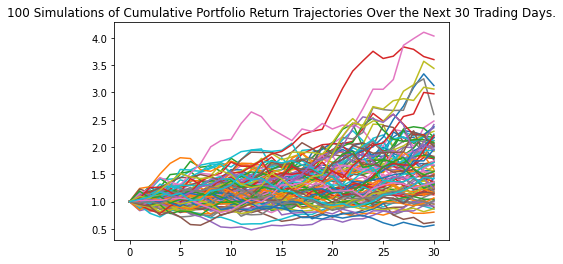

In [28]:
# Plot simulation outcomes
doodle_line_plot = doodles_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
doodle_line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")

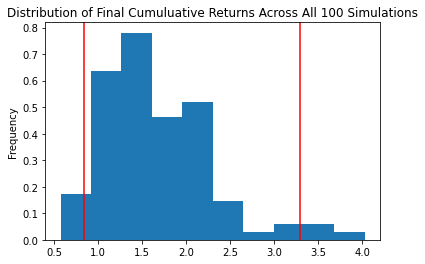

In [29]:
# Plot probability distribution and confidence intervals
dist_plot = doodles_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')


Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
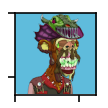
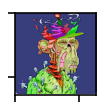
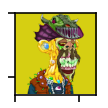
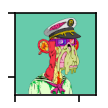
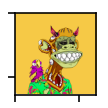
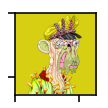
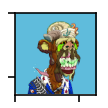
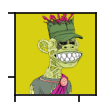
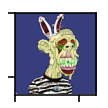
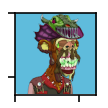

In [30]:
collection_slug = "mutant-ape-yacht-club"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

The file Data/mutant-ape-yacht-club_10012021_03312022.csv exists


/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:xlabel='event_date'>

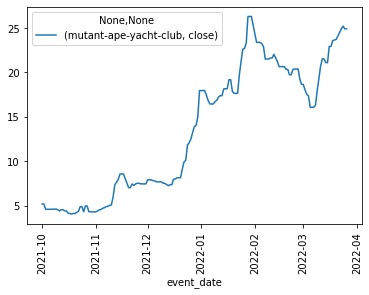

In [31]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)

df_mutant_ape = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_mutant_ape.plot(rot=90)

In [32]:
num_of_simulation =100
#num_of_years=1
#num_trading_days = 252*num_of_years
num_trading_days=30

mutant_ape_MC = MCSimulation(
    portfolio_data = df_mutant_ape,
    num_simulation = num_of_simulation,
    num_trading_days = num_trading_days
)

In [33]:
# Printing the simulation input data
mutant_ape_MC.portfolio_data.head()

mutant-ape-yacht-club             
                           close daily_return
event_date                                   
2021-10-01              5.173631          NaN
2021-10-02              5.173631     0.000000
2021-10-03              4.580623    -0.114621
2021-10-04              4.580623     0.000000
2021-10-05              4.580623     0.000000

In [34]:
# Running a Monte Carlo simulation to forecast for 1 year cumulative returns
mutant_ape_MC.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.039253,1.049161,1.037544,1.052456,0.990129,1.073587,1.021268,1.087863,1.044134,1.009634,...,0.960368,0.993565,1.004035,1.024105,0.984326,1.017016,1.011958,1.010243,0.990305,1.020621
2,1.028478,1.092827,1.026033,0.990379,0.935739,1.103276,0.990165,1.105257,1.056828,0.993652,...,0.960466,1.014641,1.085098,1.034156,1.066966,0.954763,1.025281,1.068129,1.047674,0.961314
3,1.075327,1.130306,0.976424,1.036707,0.880809,1.122572,0.989484,1.221671,1.073026,1.060176,...,1.009986,1.068306,1.041908,1.049007,1.098259,1.065773,0.921523,1.048475,1.059472,1.012776
4,1.091620,1.159741,1.069540,1.085886,0.887957,1.097754,0.925640,1.187183,1.131861,1.051026,...,0.983561,1.038179,1.060604,1.017554,1.124480,1.001859,0.875520,1.069738,1.142724,0.943156
5,1.218626,1.081809,0.989120,1.080815,0.831638,1.040210,1.017200,1.248615,1.156020,1.073623,...,0.939668,0.977582,1.044505,1.067998,1.142532,1.071861,0.857328,1.051139,1.048046,0.904517
6,1.221024,1.079628,0.897699,1.038310,0.857063,1.138105,1.056261,1.283130,1.197962,1.088617,...,0.905428,0.983353,1.098879,1.205833,1.223580,1.109248,0.842260,1.005461,1.174334,0.881875
7,1.240305,1.066729,0.898402,0.987463,0.862108,1.146469,1.078475,1.268663,1.185921,1.136116,...,0.854175,0.916169,1.010713,1.210793,1.320398,1.090222,0.811443,0.959995,1.202157,0.848950
8,1.340071,1.039014,0.859248,0.897449,0.870424,1.181934,1.137553,1.237174,1.212266,1.129804,...,0.957291,0.954500,1.069917,1.172485,1.395478,1.028921,0.856696,0.966291,1.275117,0.861057
9,1.311147,1.005438,0.864911,0.952081,0.901826,1.209325,1.156918,1.239241,1.302536,1.143431,...,0.935159,0.953491,1.088796,1.120046,1.455756,1.081968,0.885011,0.963398,1.153027,0.885458


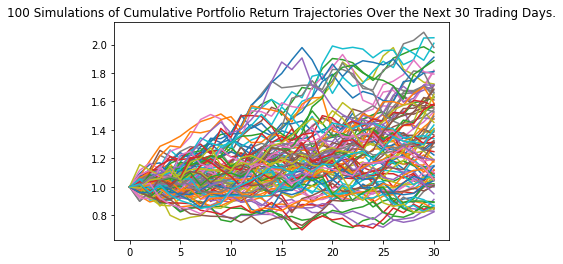

In [35]:
# Plot simulation outcomes
mutant_ape_line_plot = mutant_ape_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
mutant_ape_line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")

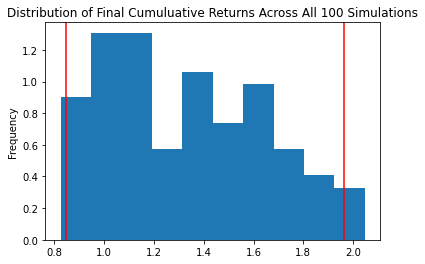

In [36]:
# Plot probability distribution and confidence intervals
dist_plot = mutant_ape_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [37]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = mutant_ape_MC.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           100.000000
mean              1.329242
std               0.319048
min               0.824496
25%               1.062706
50%               1.313632
75%               1.579196
max               2.047550
95% CI Lower      0.845285
95% CI Upper      1.962449
Name: 30, dtype: float64


In [38]:
#collection_base_url = "https://api.opensea.io/api/v1/collection/"
#collection_slug="doodles-official"

#def get_collection(collection_slug):
   # collection_url = collection_base_url+collection_slug
   # response = requests.request("GET", url)
   # collection_json=response.json()
   # return collection_json

#doodle_collection = get_collection(collection_slug)
#print(json.dumps(doodle_collection,indent=4))



Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
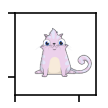
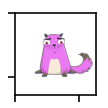
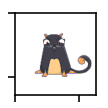
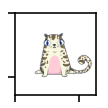
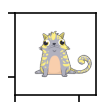
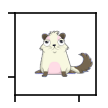
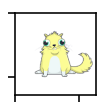
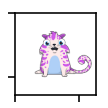
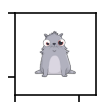
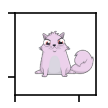

In [39]:
collection_slug="cryptokitties"
asset_limit=200
total_images_to_display=10

panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel



The file Data/cryptokitties_10012021_03312022.csv exists


/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:xlabel='event_date'>

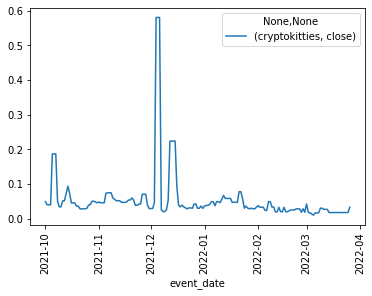

In [40]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)

df_cryptokitties = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_cryptokitties.plot(rot=90)

In [41]:
num_of_simulation =100
#num_of_years=1
#num_trading_days = 252*num_of_years
num_trading_days=30

cryptokitties_MC = MCSimulation(
    portfolio_data = df_cryptokitties,
    num_simulation = num_of_simulation,
    num_trading_days = num_trading_days
)

In [42]:
# Printing the simulation input data
cryptokitties_MC.portfolio_data.head()

cryptokitties             
                   close daily_return
event_date                           
2021-10-01      0.049171          NaN
2021-10-02      0.039983    -0.186853
2021-10-03      0.039983     0.000000
2021-10-04      0.039983     0.000000
2021-10-05      0.186709     3.669716

In [43]:
# Running a Monte Carlo simulation to forecast for 1 year cumulative returns
cryptokitties_MC.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
1,1.257000,1.635917,1.363817,0.072711,1.615959,-0.366599,2.927543,1.842932,0.488448,1.859377,...,0.103066,2.748603,1.854646e+00,0.815726,1.195035,0.999914,0.453076,0.346875,1.085993e+00,0.214389
2,1.611619,2.895345,1.234024,0.076785,1.283558,-0.567240,3.320971,1.077286,-0.473852,4.312562,...,-0.219301,4.432128,-1.330438e-02,1.009367,-0.223452,1.452965,0.908940,0.430989,-7.740279e-01,0.417410
3,3.708035,3.267822,0.179763,0.076527,-1.210769,-0.805713,-5.105689,1.695779,0.195502,6.850431,...,-0.395880,-0.163828,-2.665992e-02,1.156120,-0.340413,0.629762,0.092745,0.678989,2.247726e-01,0.737277
4,-3.200640,6.642682,0.220805,0.016760,-0.787768,0.808564,-6.114518,1.881335,0.271590,1.765186,...,-0.301512,-0.288726,-4.370593e-02,1.666664,-1.019299,-0.172035,0.148210,2.237293,4.598701e-01,0.734249
5,-7.266681,7.251521,0.165492,0.007975,-0.996772,2.334718,-1.631096,-0.197446,-0.089591,0.741205,...,-0.543257,-0.613685,-8.130084e-02,1.112896,-1.265530,-0.133081,0.419062,2.846014,8.970374e-02,-0.721188
6,-0.510291,21.881172,0.112281,0.000597,-1.913093,5.932114,1.101690,-0.227215,0.057579,1.963538,...,-0.337372,-0.635055,7.181658e-02,0.549333,-0.180925,-0.218475,0.272235,-0.686473,-6.067329e-02,-0.909467
7,-0.451042,64.553725,0.196204,0.000413,1.536764,-3.671883,1.131819,-0.414543,-0.030021,3.287969,...,-0.955799,-0.623418,1.046199e-01,0.745346,-0.216519,-0.092665,0.438214,0.428816,-1.319922e-01,0.658707
8,-0.555590,13.685848,0.332945,0.000922,3.377681,-4.364415,2.415502,-0.427365,-0.088483,4.480155,...,0.020252,-0.683910,2.447810e-01,0.730021,0.287982,-0.176458,0.235809,0.223037,-1.360782e-01,-0.086020
9,-0.576467,2.044400,0.507005,0.001788,0.629579,-4.247281,2.607294,-0.526106,-0.013218,2.607238,...,0.017143,-0.010065,2.348999e-02,-0.441768,0.184445,-0.102764,0.284446,0.230985,-5.208699e-02,-0.042131


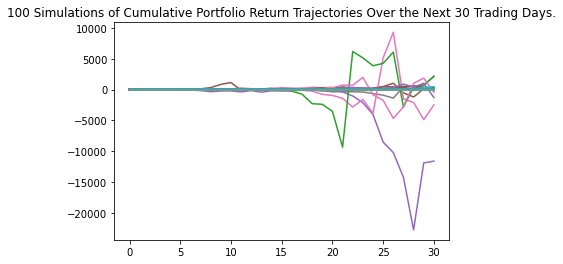

In [44]:
# Plot simulation outcomes
cryptokitties_line_plot = cryptokitties_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
cryptokitties_line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")

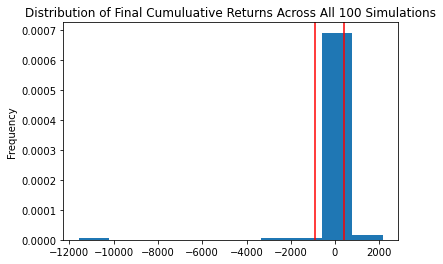

In [45]:
# Plot probability distribution and confidence intervals
dist_plot = cryptokitties_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

Column
    [0] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
        [3] Matplotlib(Figure)
        [4] Matplotlib(Figure)
        [5] Matplotlib(Figure)
        [6] Matplotlib(Figure)
        [7] Matplotlib(Figure)
        [8] Matplotlib(Figure)
        [9] Matplotlib(Figure)
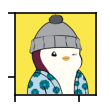
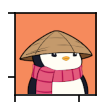
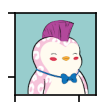
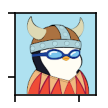
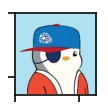
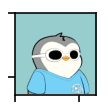
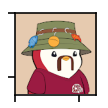
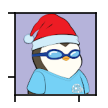
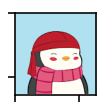
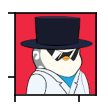

In [46]:
collection_slug="pudgypenguins"
panel = display_colleaction_assets(collection_slug,asset_limit,total_images_to_display)
panel

The file Data/pudgypenguins_10012021_03312022.csv exists


/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/sameerlakhe/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:xlabel='event_date'>

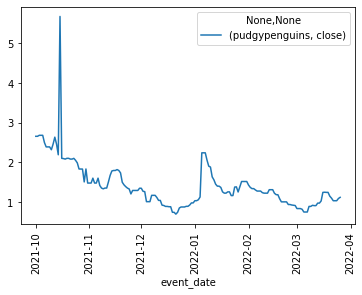

In [47]:
#get the stats for the collection for analysis
collection_stats= get_colection_stats(collection_slug)
all_collection_stats[collection_slug]=collection_stats

file_name = determine_file_name(collection_slug,start_date,end_date)
df_pudgypenguins = fetch_data_and_get_floor_sales_price(event_url,
                                         start_date,
                                         end_date,
                                         event_type,
                                         collection_slug,
                                         limit,
                                         file_name)

df_pudgypenguins.plot(rot=90)

In [48]:
num_of_simulation =100
#num_of_years=1
#num_trading_days = 252*num_of_years
num_trading_days=30

pudgypenguins_MC = MCSimulation(
    portfolio_data = df_pudgypenguins,
    num_simulation = num_of_simulation,
    num_trading_days = num_trading_days
)

In [49]:
# Printing the simulation input data
pudgypenguins_MC.portfolio_data.head()

pudgypenguins             
                   close daily_return
event_date                           
2021-10-01      2.658903          NaN
2021-10-02      2.658903     0.000000
2021-10-03      2.683906     0.009403
2021-10-04      2.683906     0.000000
2021-10-05      2.683906     0.000000

In [50]:
# Running a Monte Carlo simulation to forecast for 1 year cumulative returns
pudgypenguins_MC.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.141695,0.850377,1.164754,0.937234,0.795545,0.972239,1.171118,1.032603,1.000940,1.053373,...,1.097248,1.033463,0.994228,0.696791,1.046321,1.045285,1.107259,0.931605,0.862305,0.887249
2,0.992173,1.020302,1.483057,0.785503,0.961435,1.024318,0.899946,1.078052,1.051040,1.105781,...,0.890011,0.971939,1.196945,0.796697,0.900306,0.912082,1.166301,0.731414,0.944995,0.875855
3,1.077563,1.224023,1.401697,0.803642,1.093005,0.985875,0.877526,1.273684,0.828372,1.193946,...,0.990550,0.782586,1.230413,0.813667,1.056783,0.892658,1.030695,0.978500,0.935548,0.695666
4,0.747837,1.185382,1.178086,0.717144,1.220020,1.076085,0.818092,1.196396,0.744275,1.224696,...,0.983374,0.874151,1.574176,0.703310,1.206115,0.833998,1.078260,0.936649,0.915458,0.816740
5,0.971608,1.286902,1.418262,0.646072,1.366424,1.133266,0.945225,1.526968,0.685734,1.456480,...,0.758068,0.524690,1.235281,0.670987,1.044354,0.764332,1.010998,0.929031,0.963141,0.922620
6,0.520899,1.138496,1.649999,0.465129,1.439052,1.222268,0.939896,1.321029,0.852602,1.767319,...,0.774491,0.370441,1.075968,0.775835,1.637853,0.906068,1.380500,1.075966,0.964202,0.973526
7,0.360797,0.881299,1.858379,0.476098,1.244640,0.980502,1.171841,1.312921,0.756712,1.373030,...,0.771714,0.414524,1.235647,0.501679,1.429201,0.852718,1.822557,1.297118,1.064798,1.076199
8,0.280811,0.704364,2.138371,0.454645,1.286256,0.915856,1.027876,1.169371,0.918736,1.158639,...,0.818909,0.460934,1.141057,0.479209,1.517744,0.949031,1.371998,1.317644,1.208026,1.001340
9,0.266845,0.858556,2.239575,0.386569,1.435905,0.836750,0.941510,1.159085,1.130538,1.263204,...,0.900205,0.546240,1.215005,0.542861,1.451788,0.853027,1.579859,1.549611,1.513099,1.100688


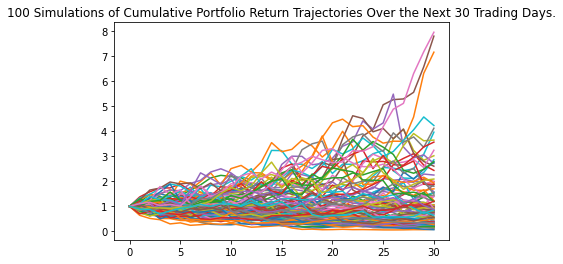

In [51]:
# Plot simulation outcomes
pudgypenguins_line_plot = pudgypenguins_MC.plot_simulation()
sim_image_name=determine_simulation_image_name(collection_slug)
pudgypenguins_line_plot.get_figure().savefig(sim_image_name, bbox_inches="tight")

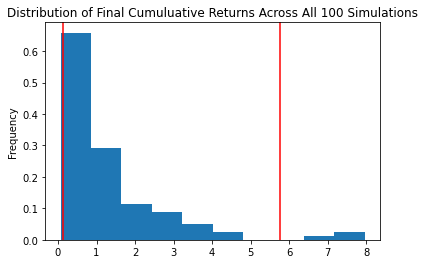

In [52]:
# Plot probability distribution and confidence intervals
dist_plot = pudgypenguins_MC.plot_distribution()
dist_image_name=determine_distribution_image_name(collection_slug)
dist_plot.get_figure().savefig(dist_image_name,bbox_inches='tight')

In [53]:
#get Etherium current price using alpaca API
def get_etherium_price():
    eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"
    # Fetch current ETH price
    eth_response_data = requests.get(eth_url).json()
    #print(json.dumps(eth_response_data, indent=2))
    eth_price = eth_response_data["data"]["1027"]["quotes"]["CAD"]["price"]
    return eth_price

eth_price = get_etherium_price()
print(f"The current value of 1 ETH as of {datetime.datetime.now()} is ${eth_price:0.2f}")

The current value of 1 ETH as of 2022-04-17 09:18:08.850751 is $3849.59


In [66]:

#print(all_collection_stats)
def get_collection_stat_filtered_df(all_collection_stats):
    filtered_collection_stats = {}
    for key in all_collection_stats.keys():
        collection_data = all_collection_stats[key]
        total_sales = collection_data["stats"]["total_sales"]
        sales_30_days = collection_data["stats"]["thirty_day_sales"]
        average_price = collection_data["stats"]["average_price"]
        filter_values={}
        filter_values["total_sales"] =total_sales
        filter_values["sales_30_days"] =sales_30_days
        filter_values["average_price"] =average_price
        filtered_collection_stats[key]=filter_values
        #filtered_collection_stats[key]=collection_data["stats"]
        
    return filtered_collection_stats
    
filtered_collection_stats = get_collection_stat_filtered_df(all_collection_stats)
#filtered_collection_stats
collection_stats_df =pd.DataFrame(filtered_collection_stats)
collection_stats_df


,boredapeyachtclub,doodles-official,mutant-ape-yacht-club,cryptokitties,pudgypenguins
total_sales,25561.000000,21001.000000,28970.000000,782066.000000,35090.000000
sales_30_days,355.000000,859.000000,1500.000000,1390.000000,2019.000000
average_price,19.283499,4.987344,10.857704,0.090137,1.514921
